In [1]:
import pandas as pd
import nltk
import numpy as np
from numpy import random as npr
import time
import string
import sklearn
#from itertools import chain, imap
#nltk.download('punkt')
#nltk.download("stopwords")
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import re
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.tree import DecisionTreeClassifier

In [2]:
df1 = pd.read_json('final_50k_221118.json', lines=True)

In [3]:
df_shuffled = df1.sample(frac=1, random_state=39)

# Reset the index
df_shuffled = df_shuffled.reset_index(drop=True)

df2 = df_shuffled[0:30000]

df3 = df2.groupby(df2["awesome_biz_id"],as_index=False).agg({"content":' '.join,"business_name":"first","is_entertainment":"first","is_traffic":"first"})


In [4]:
print("df3",df3)


df3       awesome_biz_id                                            content  \
0         biz_000003  They do not make authentic Italian calzones. O...   
1         biz_000005  They are scammers!!! DO NOT BUY PRODUCTS FROM ...   
2         biz_000009  Just opened the paper bag to find a burnt croi...   
3         biz_000014  Needed a quick car wash!!! In the sign $4.19 i...   
4         biz_000020  This service is convenient, easy, and fast. Li...   
...              ...                                                ...   
18719     biz_049988  Vonsland! I swear, THIS IS ACTUALLY A SMALL TO...   
18720     biz_049993  This is a fun place to relax, create a paintin...   
18721     biz_049994  3 stars for food and service. I have a friend ...   
18722     biz_049995  It's wasn't bad as all. It's very slow and eve...   
18723     biz_049999  Great selection.. lots of high end options.. b...   

                    business_name  is_entertainment  is_traffic  
0                         Cal

In [4]:
label = ["is_entertainment","is_traffic"]
labeldf = df3[["is_entertainment","is_traffic"]]
print(labeldf)

       is_entertainment  is_traffic
0                 False        True
1                  True        True
2                 False        True
3                 False        True
4                 False        True
...                 ...         ...
18719             False       False
18720             False       False
18721             False       False
18722              True       False
18723              True       False

[18724 rows x 2 columns]


In [6]:
df4 = df3[["business_name","content"]]
print(df4)

                    business_name  \
0                         Calzone   
1               cheebapotshop.com   
2                 Perk Coffee Bar   
3                 MB KAZMO OIL CO   
4                  Wash-N-Deliver   
...                           ...   
18719         Lucky Liquor Market   
18720             Pinot's Palette   
18721                    Diem Hen   
18722        Empire Hookah Lounge   
18723  Minute Shops Liquor & Deli   

                                                 content  
0      They do not make authentic Italian calzones. O...  
1      They are scammers!!! DO NOT BUY PRODUCTS FROM ...  
2      Just opened the paper bag to find a burnt croi...  
3      Needed a quick car wash!!! In the sign $4.19 i...  
4      This service is convenient, easy, and fast. Li...  
...                                                  ...  
18719  Vonsland! I swear, THIS IS ACTUALLY A SMALL TO...  
18720  This is a fun place to relax, create a paintin...  
18721  3 stars for food 

In [7]:
token = []
name = ["business_name","content"]
dic1 = {}
WORD = re.compile(r'\w+')
def regTokenize(text):
    words = WORD.findall(text)
    return words
for i in [0,1]:
    arrx = []
    for j in range(0,len(df4[name[i]])):
        listx = regTokenize(df4[name[i]][j])
        arrx.append(listx)
    dic1[name[i]] = arrx

In [8]:
stop_words = set(stopwords.words("english"))
for i in range(len(string.punctuation)):    
    stop_words.add(string.punctuation[i])
stop_words.add("'s")
stop_words.add(".....")

In [9]:
stemmer = PorterStemmer()
#print(dic1)
for i in [0,1]:
    arrc = []
    for j in range(0,len(dic1[name[i]])):
        flist = []
        for z in dic1[name[i]][j]:
            if z.casefold() not in stop_words:
                flist.append(stemmer.stem(z))
        arrc.append(" ".join(flist))
    dic1[name[i]] = arrc

In [10]:
tf_idf_model  = TfidfVectorizer(min_df=0.001)
#print(tf_idf_model.get_feature_names_out())
bustf = dic1["business_name"]
tf_idf_vector1 = tf_idf_model.fit_transform(bustf)
tf_idf_array1 = tf_idf_vector1.toarray()
#print(tf_idf_model.get_feature_names_out())
contf = dic1["content"]
tf_idf_vector2 = tf_idf_model.fit_transform(contf)
tf_idf_array2 = tf_idf_vector2.toarray()

In [11]:
X = np.hstack((tf_idf_array1,tf_idf_array2))
print(X.shape)

(18724, 3652)


In [16]:
# SVD dimension reduction
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=1300)
X_svd = svd.fit(X)
var_explained = svd.explained_variance_ratio_.sum()
print(var_explained)

0.8626665083797407


In [14]:
svd_var_ratios = svd.explained_variance_ratio_

In [15]:
# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [16]:
select_n_components(svd_var_ratios, 0.90)

2193

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, X_svd.n_components_+1)

ax.plot(x_values, X_svd.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(X_svd.explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('PCA with TFList : explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

In [11]:
num_topics = 37
nmf = NMF(n_components=num_topics)
nmf.fit(X)
doc_topic_matrix = nmf.transform(X)
topic_term_matrix = nmf.components_

num_top_terms = 10
feature_names = tf_idf_model.get_feature_names_out()
# for topic_idx, topic in enumerate(topic_term_matrix):
#     print("Topic #%d:" % topic_idx)
#     print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_terms - 1:-1]]))
#     print()

In [22]:
# Create a dataframe from the document-topic matrix
dfnmf = pd.DataFrame(doc_topic_matrix)

# Add a column for the original text data
#df["Text"] = bustf + contf

# Print the resulting dataframe
print(dfnmf)
print(dfnmf.shape)


             0         1         2         3         4         5         6   \
0      0.007077  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1      0.015696  0.000000  0.001932  0.002958  0.001517  0.000147  0.000474   
2      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3      0.002921  0.000000  0.000321  0.000603  0.009060  0.000277  0.000000   
4      0.003116  0.000000  0.000000  0.000117  0.002150  0.000000  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
18719  0.002438  0.090769  0.000000  0.000000  0.000000  0.093930  0.000329   
18720  0.011510  0.002112  0.000409  0.000327  0.000000  0.001122  0.000194   
18721  0.018683  0.000658  0.000684  0.000179  0.000309  0.000429  0.000000   
18722  0.016380  0.000029  0.000041  0.000000  0.000188  0.000000  0.000239   
18723  0.002305  0.108404  0.000000  0.000000  0.000000  0.001718  0.067462   

             7         8         9   ...        27 

is_entertainment
(14979, 37) (14979,)
Accuracy: 0.83
[[2876  325]
 [ 296  248]] : is the confusion matrix
0.4328097731239092 : is the precision score
0.45588235294117646 : is the recall score
0.4440465532676812 : is the f1 score
is_traffic
(14979, 37) (14979,)
Accuracy: 0.76
[[ 244  443]
 [ 454 2604]] : is the confusion matrix
0.8546110928782409 : is the precision score
0.8515369522563767 : is the recall score
0.8530712530712531 : is the f1 score


Text(0.5, 1.0, 'Precision Recall Curve for Decision Tree Classifier')

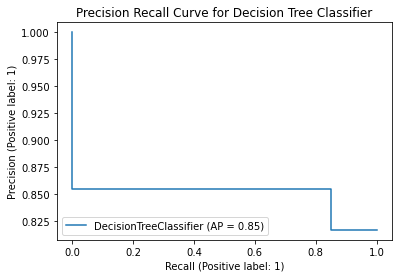

In [23]:
npr.seed(123)
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
# perform encoding on training and testing dataset to differentiate between different labels and assign them to 0 or 1
for j in [0,1]:
    print(label[j])
    X_train, X_test, y_train, y_test = train_test_split(dfnmf, labeldf[label[j]], test_size=0.2, random_state=42)
    print(X_train.shape,y_train.shape)
    # create and fit the Naive Bayes model
    #nb_model = MultinomialNB()
    nb_model = DecisionTreeClassifier()
    nb_model.fit(X_train, y_train)

    # make predictions on the test data
    y_pred = nb_model.predict(X_test)
    '''Encoder = LabelEncoder()
    y_train_svm = Encoder.fit_transform(y_train)
    y_test_svm = Encoder.fit_transform(y_test)
    SVM = svm.SVC(C=1.0, kernel = 'linear', degree = 3, gamma = 'auto')
    SVM.fit(X_train,y_train_svm)
    predictions_SVM = SVM.predict(X_test)
    print("Accuracy: ", accuracy_score(predictions_SVM, y_test_svm)*100)'''
    
    '''
    param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
    }
    nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
    nbModel_grid.fit(X_train, y_train)
    print(nbModel_grid.best_estimator_)
    y_pred = nbModel_grid.predict(X_test)'''
    # calculate accuracy
    #accuracy = (y_pred == y_test).sum() / len(y_test)
    
    '''from sklearn.model_selection import RepeatedStratifiedKFold
    cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                        n_repeats=3, 
                                        random_state=999)
    from sklearn.preprocessing import PowerTransformer
    params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
    gs_NB = GridSearchCV(estimator=nb_model, 
                         param_grid=params_NB, 
                         cv=cv_method,
                         verbose=1, 
                         scoring='accuracy')
    Data_transformed = PowerTransformer().fit_transform(X_test)
    gs_NB.fit(Data_transformed, y_test);
    gs_NB.best_params_
    gs_NB.best_score_
    results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
    results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']
    # predict the target on the test dataset
    predict_test = gs_NB.predict(Data_transformed)
    # Accuracy Score on test dataset
    accuracy_test = accuracy_score(y_test,predict_test)
    print('accuracy_score on test dataset : ', accuracy_test)
    
    print(confusion_matrix(y_test, predict_test), ": is the confusion matrix")
  
    print(precision_score(y_test, predict_test), ": is the precision score")
    print(recall_score(y_test, predict_test), ": is the recall score")
    print(f1_score(y_test, predict_test), ": is the f1 score")
    # Get the misclassified examples
    misclassified = X_test[predict_test != y_test]
    mis = misclassified.index.tolist()
    print(mis)
    # Print a few examples of misclassified comments
    for x in range(5):
        if x < len(mis): # Check if the index is within bounds
            predictor = df2[name].iloc[mis[x]]#[name[i]] # Replace 'comment' with the actual column name
            actual_label = labeldf[label[i]].iloc[mis[x]]#[label[j]] # Replace 'label' with the actual column name
            print(f"Predictor: {predictor}")
            print(f"Actual label: {actual_label}")
            print("\n")
        else:
            print("No more misclassified examples.")
            break
    probabilities = gs_NB.predict_proba(np.array(X_test))
    predictions = probabilities[:, 1]
    fpr, tpr, threshold = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label=label[j]+' AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()'''
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')


    print(confusion_matrix(y_test, y_pred), ": is the confusion matrix")


    print(precision_score(y_test, y_pred), ": is the precision score")

    print(recall_score(y_test, y_pred), ": is the recall score")

    print(f1_score(y_test, y_pred), ": is the f1 score")

    # # Get the misclassified examples
    # misclassified = X_test[y_pred != y_test]
    # mis = misclassified.index.tolist()
    # print(mis)
    # Print a few examples of misclassified comments
    # for x in range(5):
    #     if x < len(mis): # Check if the index is within bounds
    #         predictor = df2[name].iloc[mis[x]]#[name[i]] # Replace 'comment' with the actual column name
    #         actual_label = labeldf[label[i]].iloc[mis[x]]#[label[j]] # Replace 'label' with the actual column name
    #         print(f"Predictor: {predictor}")
    #         print(f"Actual label: {actual_label}")
    #         print("\n")
    #     else:
    #         print("No more misclassified examples.")
    #         break

#     probabilities = nb_model.predict_proba(np.array(X_test))
#     predictions = probabilities[:, 1]
#     fpr, tpr, threshold = roc_curve(y_test, predictions)
#     roc_auc = auc(fpr, tpr)

#     plt.title('Receiver Operating Characteristic')
#     plt.plot(fpr, tpr, 'b', label=label[j]+' AUC = %0.2f' % roc_auc)
#     plt.legend(loc='lower right')
#     plt.plot([0, 1], [0, 1], 'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
# plt.show()
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_predictions(y_test,y_pred,name="DecisionTreeClassifier")
display.ax_.set_title("Precision Recall Curve for Decision Tree Classifier")

is_entertainment
(14979, 1000) (14979,)
Fitting 15 folds for each of 50 candidates, totalling 750 fits
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 20}
0.4894002580922795
accuracy_score on test dataset :  0.9124165554072096
[[3142   59]
 [ 269  275]] : is the confusion matrix
0.8233532934131736 : is the precision score
0.5055147058823529 : is the recall score
0.6264236902050114 : is the f1 score
is_traffic
(14979, 1000) (14979,)


c:\Users\megal\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Fitting 15 folds for each of 50 candidates, totalling 750 fits
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5}
0.900662018289973
accuracy_score on test dataset :  0.8283044058744994
[[  76  611]
 [  32 3026]] : is the confusion matrix
0.8320043992301347 : is the precision score
0.9895356442119032 : is the recall score
0.9039581777445855 : is the f1 score


c:\Users\megal\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


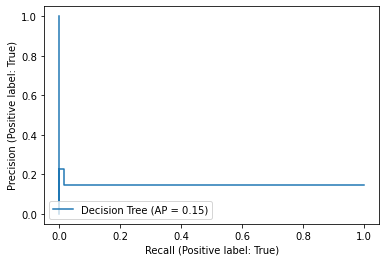

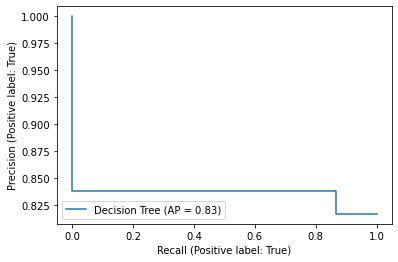

In [19]:
# with cross validation
#nmf with CV
#With Cross Validation
for j in [0,1]:
    print(label[j])
    X_train, X_test, y_train, y_test = train_test_split(dfnmf, labeldf[label[j]], test_size=0.2, random_state=42)
    print(X_train.shape,y_train.shape)
    # create and fit the Naive Bayes model
    #nb_model = MultinomialNB()
    tree_model = DecisionTreeClassifier()
    tree_model.fit(X_train, y_train)

    # make predictions on the test data
    y_pred = tree_model.predict(X_test)
    '''
    param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
    }
    nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
    nbModel_grid.fit(X_train, y_train)
    print(nbModel_grid.best_estimator_)
    y_pred = nbModel_grid.predict(X_test)'''
    # calculate accuracy
    #accuracy = (y_pred == y_test).sum() / len(y_test)
    
    from sklearn.model_selection import RepeatedStratifiedKFold

    cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                        n_repeats=3, 
                                        random_state=999)
    from sklearn.preprocessing import PowerTransformer
    params_tree = {'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]}

    gs_tree = GridSearchCV(estimator=tree_model, 
                         param_grid=params_tree, 
                         cv=cv_method,
                         verbose=1, 
                         scoring='f1')

    Data_transformed = PowerTransformer().fit_transform(X_test)

    gs_tree.fit(Data_transformed, y_test)
    print(gs_tree.best_params_)
    print(gs_tree.best_score_)
    results_NB = pd.DataFrame(gs_tree.cv_results_['params'])
    results_NB['test_score'] = gs_tree.cv_results_['mean_test_score']
    # predict the target on the test dataset
    predict_test = gs_tree.predict(Data_transformed)

    # Accuracy Score on test dataset
    accuracy_test = accuracy_score(y_test,predict_test)
    print('accuracy_score on test dataset : ', accuracy_test)
    
    print(confusion_matrix(y_test, predict_test), ": is the confusion matrix")
  

    print(precision_score(y_test, predict_test), ": is the precision score")

    print(recall_score(y_test, predict_test), ": is the recall score")

    print(f1_score(y_test, predict_test), ": is the f1 score")

    # # Get the misclassified examples
    # misclassified = X_test[predict_test != y_test]
    # mis = misclassified.index.tolist()
    # print(mis)
    # # Print a few examples of misclassified comments
    # for x in range(5):
    #     if x < len(mis): # Check if the index is within bounds
    #         predictor = df2[name].iloc[mis[x]]#[name[i]] # Replace 'comment' with the actual column name
    #         actual_label = labeldf[label[i]].iloc[mis[x]]#[label[j]] # Replace 'label' with the actual column name
    #         print(f"Predictor: {predictor}")
    #         print(f"Actual label: {actual_label}")
    #         print("\n")
    #     else:
    #         print("No more misclassified examples.")
    #         break
    # roc auc curve
#     probabilities = gs_tree.predict_proba(Data_transformed)
#     predictions = probabilities[:, 1]
#     fpr, tpr, threshold = roc_curve(y_test, predictions)
#     roc_auc = auc(fpr, tpr)

#     plt.title('Receiver Operating Characteristic')
#     plt.plot(fpr, tpr, 'b', label=label[j]+' AUC = %0.2f' % roc_auc)
#     plt.legend(loc='lower right')
#     plt.plot([0, 1], [0, 1], 'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
# plt.show()
    
    from sklearn.metrics import plot_precision_recall_curve
    plot_precision_recall_curve(gs_tree, X_test, y_test, name = 'Decision Tree')